# Load required libraries

In [47]:
import cv2
from math import sqrt 
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
from skimage.feature import canny
import matplotlib.pyplot as plt 
import math
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
from skimage import io
import glob
import numpy as np
from PIL import Image, ImageDraw, ImageFont
#img = Image.open('C:/Users/Shraddha Pawar/Desktop/knicking/retinal_images/outputIM000167.JPG')

# Read the original image and vessel segmented image by UNET

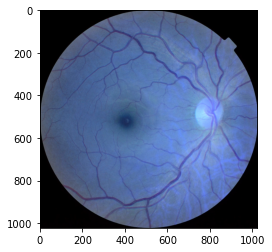

In [48]:
img = cv2.imread('C:/Users/Shraddha Pawar/Desktop/5980_right.jpg')
img_pred = cv2.imread('C:/Users/Shraddha Pawar/Desktop/5980_right_pretty.png')
img1 = Image.open('C:/Users/Shraddha Pawar/Desktop/5980_right.jpg')
plt.imshow(img)

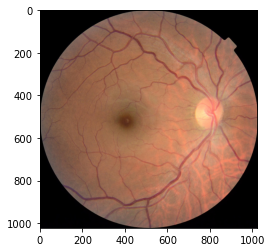

In [49]:
_,_,b = cv2.split(img_pred)
plt.imshow(img1)

# find out nicking points from segmented image

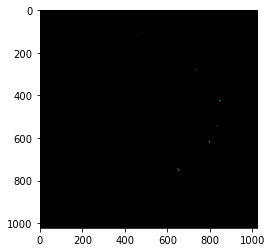

In [50]:
hsv = cv2.cvtColor(img_pred, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, (36, 25, 25), (70, 255,255))
imask = mask>0
green = np.zeros_like(img_pred, np.uint8)
green[imask] = img_pred[imask]
plt.imshow(green, cmap='gray')

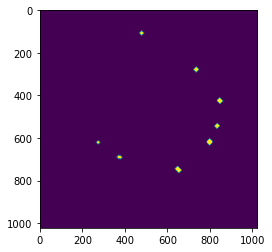

In [51]:
#thicken the mask for better visulaization 
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(11,11))
eroded = cv2.dilate(mask, kernel)
dilated = cv2.dilate(eroded,kernel)
plt.imshow(dilated)


# plot the regions on original image

8


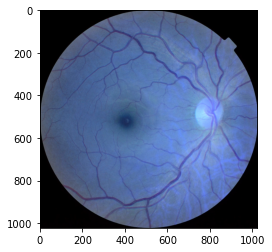

In [52]:
# find contours from the mask and mark the corresponding rectangle on original image
from PIL import Image
contours, hier = cv2.findContours(dilated, cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
cropped_box = []
cropped_img = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    xleft = x
    xright = xleft + w 
    ytop = y
    ybottom = ytop + h
    xcenter = int((xleft+xright)/2)
    ycenter = int((ytop+ybottom)/2)
    xl = xcenter - 64
    width = xl + 128
    yt = ycenter - 64 
    height = yt + 128 
    cropped_image = img[yt:height, xl:width]
    cropped_resized = cv2.resize(cropped_image, (224, 224), interpolation = cv2.INTER_NEAREST)
    cropped_img.append(cropped_resized)
print(len(contours))
plt.imshow(img)

In [53]:
unknown_sub_images = np.array(cropped_img)

In [54]:
unknown_sub_images.shape

(8, 224, 224, 3)

# Read folders of block data for AVC and Normal blocks to train the classifier

In [55]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2
import os
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import layer_normalization
import os
import joblib
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [56]:
"""
@author: Savita Walia
This code explains the process of using pretrained weights (VGG16) 
as feature extractors for traditional machine learning classifiers (Random Forest). 
"""

# Read input images and assign labels based on folder names
print(os.listdir("C:/Users/Shraddha Pawar/Desktop/New_nicking_data/"))

SIZE = 224  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("C:/Users/Shraddha Pawar/Desktop/New_nicking_data/valid/*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

['5980_right.jpg', '5980_right.png', '5980_right_pretty.png', 'AVC', 'AVC_224', 'extract knicking region_25_20_2021.ipynb', 'final.png', 'Normal', 'Normal_224', 'rf_feature_classifier.sav', 'train', 'valid']
AVC
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\1607_right_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\1674_left_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\1688_left_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\1777_right_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\1953_left_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\1972_right_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\2008_right_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\2190_left_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\2203_right_output.jpg
C:/Users/Shraddha Pawar/Desktop/New_nicking_data/train\AVC\2222

# transform the labels from categorical to numerical

In [57]:
#Encode labels from text to integers.
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

###################################################################
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0
#One hot encode y values for neural network. 

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [58]:
import tensorflow as tf
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# extract training features using vggnet

In [59]:
#############################

#Load model without classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
#test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
#train_summary_writer = tf.summary.create_file_writer(train_log_dir)
#test_summary_writer = tf.summary.create_file_writer(test_log_dir)
VGG_model.summary()  #Trainable parameters will be 0

#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_for_RF = features #This is our X input to RF

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# predict one image (generate features) using vgnet

In [60]:
# #######predict one image#####
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# image = img_to_array(img)
# image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# from keras.applications.vgg19 import preprocess_input
# image = preprocess_input(image)
# yhat = VGG_model.predict(image)


In [21]:
# yhat2 = yhat.reshape(yhat.shape[0], -1)

In [27]:
# prediction_RF = loaded_model.predict(yhat2)
# prediction_RF = le.inverse_transform(prediction_RF)

# Train random forest using features extracted by vggnet and save the model on disk

In [61]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import joblib
import pickle

RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

# save the model to disk
filename = 'C:/Users/Shraddha Pawar/Desktop/rf_feature_classifier.sav'
pickle.dump(RF_model, open(filename, 'wb'))

# Extract features of test images using vggnet

In [62]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# load saved and trained RF model 

In [63]:
loaded_model = pickle.load(open('C:/Users/Shraddha Pawar/Desktop/rf_classifier.sav', 'rb'))
prediction_RF = loaded_model.predict(X_test_features)
prediction_RF = le.inverse_transform(prediction_RF)
#Print overall accuracy
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.6095238095238096


<AxesSubplot:>

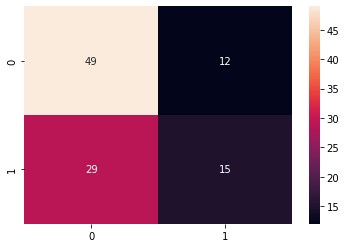

In [64]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_RF)

#print(cm)
sns.heatmap(cm, annot=True)

# extract sub_images from unet detections 

In [65]:
unknown_features =  VGG_model.predict(unknown_sub_images)

In [66]:
unknown_features = unknown_features.reshape(unknown_features.shape[0], -1)

In [67]:
unknown_features

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.09785759,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

# perform predictions saved RF model

In [68]:
#Now predict using the trained RF model. 
prediction_RF = loaded_model.predict(unknown_features)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [69]:
prediction_RF

array(['AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'Normal'],
      dtype='<U6')

In [70]:
len(contours)

8

In [71]:
predicted_labels = np.array(prediction_RF)

In [72]:
img_new2 = cv2.imread('C:/Users/Shraddha Pawar/Desktop/5980_right.jpg')

In [73]:
B = predicted_labels.tolist()
B

['AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'AVC', 'Normal']

In [74]:
# Iterate over list items by index pos
position = []
for i in range(len(B)):
    # Check if items matches the given element
    if B[i] == 'AVC':
        pos = i
        position.append(pos)
    

In [75]:
position

[0, 1, 2, 3, 4, 5, 6]

# plot filtered image blocks on the image

8


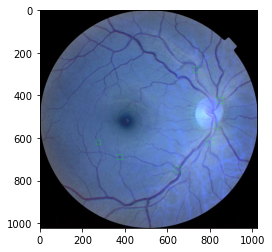

In [76]:
for p in position: 
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(contours[p])
    # draw a green rectangle to visualize the bounding rect
    font = cv2.FONT_HERSHEY_SIMPLEX
#   # text
    text ='nicking'
    # org
    org = (x, y)
    # fontScale
    fontScale = 0
    # Red color in BGR
    thickness = 2
    color = (255, 69, 0)
    A = cv2.rectangle(img_new2, (x, y), (x+w, y+h), (0, 255, 0), 1)
    #cv2.putText(img, text, org, font, fontScale, 
                  #color, thickness, cv2.LINE_AA, False)
    #cropped = A[x:x+w, y:y+h, :]
        #im = A[x:x+w, y:y+h]
    #im2 = cv2.resize(im, (224, 224))
        #cropped_img.append(im)

print(len(contours))
# cv2.drawContours(img, contours, -1, (255, 255, 0), 1)
plt.imshow(img_new2)
#cv2.imwrite('C:/Users/Shraddha Pawar/Desktop/knicking/detected/13.png', img) 

In [77]:
cv2.imwrite('C:/Users/Shraddha Pawar/Desktop/final.png', img_new2) 

True